# Imports

In [1]:
import kagglehub 
import pandas as pd
import numpy as np
import os
import zipfile

In [2]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading CSV from Kaggle API 

In [3]:

# Download latest version
path = kagglehub.dataset_download("justinas/nba-players-data")
print("Path to dataset files:", path)

Path to dataset files: /Users/samarsingh/.cache/kagglehub/datasets/justinas/nba-players-data/versions/5


In [4]:
# List all files in the directory to find the specific file
files = os.listdir(path) #--> ['file name']
print("Files in the dataset directory:", files)

# Assuming you want to read a CSV file, find the relevant file and load it
csv_file_path = os.path.join(path, files[0])  # Replace with the actual filename
df = pd.read_csv(csv_file_path)
df.head()
%config InlineBackend.print_rows = 5


Files in the dataset directory: ['all_seasons.csv']


In [5]:
b = False
for i in df.index:
    if (i != df.iloc[i, 0]):
        print(i)
        break
    b = True
if b==True:
    df.drop(df.columns[0], axis = 1, inplace = True)

In [6]:
df['college'].fillna('Untraditional', inplace = True)

In [7]:
nba_top10 = df.copy()
#storing highest colleges having largest number of draftees   
arr_10 = nba_top10.groupby('college').agg({'age':'count'}).sort_values('age', ascending = False).head(25).index.to_numpy()

In [8]:
nba_top10 = nba_top10[nba_top10['college'].apply(lambda x: x in arr_10)]

In [9]:
nba_top10.columns[11: 21]

Index(['pts', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct',
       'ts_pct', 'ast_pct', 'season'],
      dtype='object')

In [10]:
category_dropdown = widgets.Dropdown(
    options=nba_top10['college'].unique(),
    description='College:',
    value='UCLA'
)
#columns containing stats located from index 11 --> 21 (options for stats in our dropdown)
stats_dropdown = widgets.Dropdown(
    options=nba_top10.columns[11: 21],
    description='Stat:',
    value='pts'
)
stats_dropdown #example

Dropdown(description='Stat:', options=('pts', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', '…

In [11]:
#confirm approach to round any year down to a divisor of 5
for i in nba_top10['season'].value_counts().index:
    print((int(i.split('-')[0])//5)*5)

2015
2015
2015
2010
2015
2010
2010
2020
2020
2015
2010
2020
2010
2005
2005
2005
2005
2005
2000
2000
2000
2000
2000
1995
1995
1995
1995


In [12]:
#roudning player's year down into 5 year buckets
def fiveYear(szn):
    return (int(szn.split('-')[0])//5)*5

In [13]:
nba_top10['5Year'] = nba_top10['season'].apply(lambda x: fiveYear(x))

In [14]:
nba_top10.columns

Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season', '5Year'],
      dtype='object')

In [15]:
nba_top10[nba_top10['college'] == 'Kansas'].groupby('5Year', as_index=False)['pts'].mean()

,5Year,pts
0,1995,6.634615
1,2000,9.665714
2,2005,7.887500
3,2010,7.119118
4,2015,8.847297
5,2020,10.357895


# Create column that has years in league during a respective season

In [16]:
#type of column is unorthodox and must be processed unconvetnionally as:
# nba_top10['season'].str.split('-')[0] refuses to extract first column of the matrix
#shape of matrix is currently [m, none]?
j = 0
for i in nba_top10['season'].str.split('-'):
    
    print(i[0])
    j+=1
    if j==10:
        break

# above currectly extracts first year in the season
arr = []
split = nba_top10['season'].str.split('-')
for i in split:
    arr.append(int(i[0]))

np.array(arr).shape

1996
1996
1996
1996
1996
1996
1996
1996
1996
1996


(6751,)

In [17]:
len(arr) == len(nba_top10['draft_year'])

True

In [18]:
# those who were undracted or had unconventional route to the nba (i.e --> notable names Luka Doncic, Wemby must be undrafted_
# and thus have NA values under draft_year --> replace these null val and represent them as 0
nba_top10['draft_year'].value_counts().head(2)

draft_year
Undrafted    750
2003         303
Name: count, dtype: int64

In [19]:
nba_top10['draft_year'].replace('Undrafted', None, inplace=True)
nba_top10['draft_year'].fillna(0, inplace = True)
nba_top10['start_season'] = arr
#undrafted players can now be filtered numerically:
nba_top10[nba_top10['draft_year'] == 0]

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,5Year,start_season
88,Jaren Jackson,WAS,29.0,198.12,95.254320,Georgetown,USA,0,Undrafted,Undrafted,...,0.9,1.7,0.030,0.104,0.167,0.520,0.090,1996-97,1995,1996
165,Duane Ferrell,IND,32.0,200.66,97.522280,Georgia Tech,USA,0,Undrafted,Undrafted,...,1.1,2.3,0.066,0.091,0.181,0.521,0.100,1996-97,1995,1996
176,Darrick Martin,LAC,26.0,180.34,77.110640,UCLA,USA,0,Undrafted,Undrafted,...,4.1,-4.5,0.016,0.060,0.232,0.539,0.292,1996-97,1995,1996
197,Keith Askins,MIA,29.0,203.20,101.604608,Alabama,USA,0,Undrafted,Undrafted,...,1.0,6.1,0.059,0.127,0.108,0.557,0.068,1996-97,1995,1996
199,Scott Williams,PHI,29.0,208.28,104.326160,North Carolina,USA,0,Undrafted,Undrafted,...,0.7,-4.6,0.126,0.205,0.127,0.529,0.049,1996-97,1995,1996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12795,Jack White,DEN,25.0,200.66,102.058200,Duke,Australia,0,Undrafted,Undrafted,...,0.2,-14.1,0.086,0.177,0.133,0.517,0.093,2022-23,2020,2022
12809,Jose Alvarado,NOP,25.0,182.88,81.192968,Georgia Tech,USA,0,Undrafted,Undrafted,...,3.0,3.7,0.022,0.087,0.191,0.525,0.199,2022-23,2020,2022
12818,Johnny Juzang,UTA,22.0,198.12,94.800728,UCLA,USA,0,Undrafted,Undrafted,...,0.4,-17.7,0.029,0.122,0.187,0.411,0.051,2022-23,2020,2022
12837,Joe Ingles,MIL,35.0,205.74,99.790240,Untraditional,Australia,0,Undrafted,Undrafted,...,3.3,2.5,0.012,0.102,0.122,0.616,0.181,2022-23,2020,2022


In [20]:
nba_top10.isnull().sum() == 0 #confirm no outstanding null vals

player_name          True
team_abbreviation    True
age                  True
player_height        True
player_weight        True
college              True
country              True
draft_year           True
draft_round          True
draft_number         True
gp                   True
pts                  True
reb                  True
ast                  True
net_rating           True
oreb_pct             True
dreb_pct             True
usg_pct              True
ts_pct               True
ast_pct              True
season               True
5Year                True
start_season         True
dtype: bool

In [21]:
nba_top10.columns

Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season', '5Year',
       'start_season'],
      dtype='object')

In [22]:
#Clean draft years for undrafted players, this confirms non-digit values are uniquely only undrafted, locate and replace undrafted
#groups by each undrafted player and pulls their minimum start season to find the year they played first nba game
nba_top10[nba_top10['draft_year'].astype(str).str.isdigit() == False]['draft_year'].value_counts()
mapped = nba_top10[nba_top10['draft_year']==0].groupby('player_name').agg(min)['start_season']
print(f'{mapped.shape[0]} unique undrafted players in top 10 schools')

258 unique undrafted players in top 10 schools


In [23]:
nba_top10[nba_top10['draft_year'] == 0]

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,5Year,start_season
88,Jaren Jackson,WAS,29.0,198.12,95.254320,Georgetown,USA,0,Undrafted,Undrafted,...,0.9,1.7,0.030,0.104,0.167,0.520,0.090,1996-97,1995,1996
165,Duane Ferrell,IND,32.0,200.66,97.522280,Georgia Tech,USA,0,Undrafted,Undrafted,...,1.1,2.3,0.066,0.091,0.181,0.521,0.100,1996-97,1995,1996
176,Darrick Martin,LAC,26.0,180.34,77.110640,UCLA,USA,0,Undrafted,Undrafted,...,4.1,-4.5,0.016,0.060,0.232,0.539,0.292,1996-97,1995,1996
197,Keith Askins,MIA,29.0,203.20,101.604608,Alabama,USA,0,Undrafted,Undrafted,...,1.0,6.1,0.059,0.127,0.108,0.557,0.068,1996-97,1995,1996
199,Scott Williams,PHI,29.0,208.28,104.326160,North Carolina,USA,0,Undrafted,Undrafted,...,0.7,-4.6,0.126,0.205,0.127,0.529,0.049,1996-97,1995,1996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12795,Jack White,DEN,25.0,200.66,102.058200,Duke,Australia,0,Undrafted,Undrafted,...,0.2,-14.1,0.086,0.177,0.133,0.517,0.093,2022-23,2020,2022
12809,Jose Alvarado,NOP,25.0,182.88,81.192968,Georgia Tech,USA,0,Undrafted,Undrafted,...,3.0,3.7,0.022,0.087,0.191,0.525,0.199,2022-23,2020,2022
12818,Johnny Juzang,UTA,22.0,198.12,94.800728,UCLA,USA,0,Undrafted,Undrafted,...,0.4,-17.7,0.029,0.122,0.187,0.411,0.051,2022-23,2020,2022
12837,Joe Ingles,MIL,35.0,205.74,99.790240,Untraditional,Australia,0,Undrafted,Undrafted,...,3.3,2.5,0.012,0.102,0.122,0.616,0.181,2022-23,2020,2022


In [24]:
#use series of uniwue undrafted players and their start season to map onto reald df and update their start season
#maps based on our index which in ther nace --> access player names and map year values onto draft_year of undrafted
nba_top10.loc[nba_top10['draft_year'] == 0, 'draft_year'] = nba_top10['player_name'].map(mapped)
#convert in case floats are present
nba_top10['draft_year'] = nba_top10['draft_year'].astype(int)

# nba_top10[(nba_top10['draft_round'] == 'Undrafted')] #confirms all have been now mapped

nba_top10['draft_year'].value_counts()
#check if mapped correctly (i.e ensuring no non-year values in col 

# nba_top10[nba_top10['draft_year'].isna()].apply(lambda

draft_year
2005    375
2003    332
2008    311
2001    307
1996    307
2004    284
1998    265
2006    262
2014    255
2009    253
2012    231
2002    230
2011    225
2013    224
2000    217
2007    210
2010    202
2015    189
2017    189
2016    188
1995    187
1999    184
1997    173
2018    172
2019    132
1992    122
1994    111
2020    106
1993     91
2021     69
1991     65
1989     63
1990     56
2022     40
1988     37
1987     33
1984     19
1986     16
1985     12
1981      5
1983      1
1982      1
Name: count, dtype: int64

In [25]:

nba_top10['yearInLeague'] = nba_top10['start_season'] - nba_top10['draft_year']

In [26]:
#rookie seasons
def rookieSeason(name):
    return nba_top10[(nba_top10['yearsLeague'] == 0) & (nba_top10['player_name'].str.contains(name))]
rookies = nba_top10[nba_top10['yearInLeague'] == 0]

In [27]:
best_player = rookies[nba_top10['college'] == 'UCLA'].sort_values('pts', ascending = False).reset_index()
best_year = best_player.iloc[0, list(rookies.columns).index('net_rating')+1].astype(int)
print(best_year)

-5


/var/folders/07/k36kpm9j4sb2dnj364cnshx00000gn/T/ipykernel_84998/1741623170.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_player = rookies[nba_top10['college'] == 'UCLA'].sort_values('pts', ascending = False).reset_index()


In [28]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def outputPrint(category, stat):
    filtered = rookies[nba_top10['college'] == category].groupby('5Year', as_index=False)[stat].mean()
    timeY = rookies[rookies['college'] == category].groupby('start_season', as_index=False)[stat].mean()
    avg_stat = rookies[rookies['college'] == category][stat].mean()
    figure1 = px.bar(filtered, x = '5Year', y = stat, title=f'{category} School Average Rookie Points')
    figure2 = px.line(timeY, x = 'start_season', y = stat)
    #average stat for the selected school
    figure2.add_hline(y = avg_stat, line_dash = 'dot', annotation_text= category + ' average ' + stat + ': ' + str(np.round(avg_stat, 2)), 
              annotation_position="bottom right")
    #best player in the selected dropdowns
    best_player = rookies[nba_top10['college'] == category].sort_values(stat, ascending = False).reset_index()
    name = best_player.iloc[0, 1]
    best_stat = best_player.iloc[0, list(rookies.columns).index(stat)+1].astype(int)
    name = name + ' best ' + stat +' :' +  str(best_stat)
    best_year = best_player.iloc[0, list(rookies.columns).index('draft_year')+1].astype(int)
    # print(best_player.shape)
    figure2.add_hline(y = avg_stat, line_dash = 'dot', annotation_text= category + ' average ' + stat + ': ' + str(np.round(avg_stat, 2)), 
              annotation_position="bottom right")

    figure2.add_vline(x=best_year, line_dash = 'dot', line_color = 'red', annotation_text = name, annotation_position = "top right")

    
    # print(f'School Being Described: {category}')
    figure1.show()
    figure2.update_layout(xaxis=dict(range=[1995, 2025]))
    figure2.show()



In [29]:
import warnings
warnings.filterwarnings("ignore")

widgets.interactive(outputPrint, category=category_dropdown, stat = stats_dropdown)


interactive(children=(Dropdown(description='College:', index=2, options=('Louisiana State', 'North Carolina', …

# US College Athletes vs Nontraditional Athletes drafted into NBA Trends
#### Nontraditional defined as players direct from high school, overseas, G-League, etc.

In [30]:
df[df['player_name'] == 'Luka Doncic']

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
10605,Luka Doncic,DAL,20.0,200.66,98.883056,Untraditional,Slovenia,2018,1,3,...,21.2,7.8,6.0,-3.1,0.036,0.198,0.296,0.545,0.317,2018-19
11092,Luka Doncic,DAL,21.0,200.66,104.326160,Untraditional,Slovenia,2018,1,3,...,28.8,9.4,8.8,5.3,0.036,0.224,0.355,0.585,0.454,2019-20
11670,Luka Doncic,DAL,22.0,200.66,104.326160,Untraditional,Slovenia,2018,1,3,...,27.7,8.0,8.6,3.9,0.024,0.202,0.350,0.587,0.425,2020-21
12099,Luka Doncic,DAL,23.0,200.66,104.326160,Untraditional,Slovenia,2018,1,3,...,28.4,9.1,8.7,3.5,0.025,0.230,0.368,0.571,0.458,2021-22
12740,Luka Doncic,DAL,24.0,200.66,104.326160,Untraditional,Slovenia,2018,1,3,...,32.4,8.6,8.0,2.1,0.024,0.224,0.368,0.609,0.408,2022-23


In [31]:
df['draft_year'].replace('Undrafted', 0, inplace=True)
lol = df[df['college'].astype(str) == 'Untraditional'].groupby('player_name').agg({'pts':'mean'}).sort_values('pts', ascending = False)
lol.shape

(361, 1)

In [32]:
lol.head()

,pts
player_name,
Luka Doncic,27.70
LeBron James,27.20
Kobe Bryant,24.20
Giannis Antetokounmpo,23.25
Nikola Jokic,20.40


In [33]:
#ratio of overseas players over total players per year currently active in nba over time
ratio = []

trend = df.groupby('season').apply(lambda x: x[x['college'] == 'Untraditional'].shape[0]/x.shape[0]).reset_index()

arr = []
split = trend['season'].str.split('-')
for i in split:
    arr.append(int(i[0]))
trend['season'] = arr
# trend['season'].apply(lambda x: fiveYear(x))

fig = px.line(data_frame=trend, x='season', y=0, title="Ratio of Nontraditional vs. College Draftees")
fig.update_layout(xaxis=dict(range=[1995, 2023]), yaxis_title = 'Ratio')
fig.show()


# Average Change in weight over Career of nba players

In [34]:
#gather the weight at start of career and end of career and compute differesce, need years in league col
arr = []
split = df['season'].str.split('-')
for i in split:
    arr.append(int(i[0]))
df['start'] = np.array(arr).astype(int)
df['yearsInLeague'] = arr - np.array(df['draft_year']).astype(int)


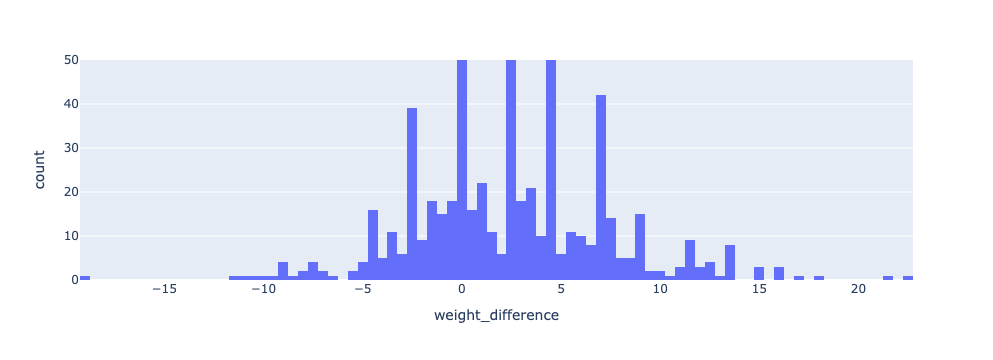

In [35]:
diff = df.groupby('player_name').apply(lambda x: x.loc[x['yearsInLeague'] == x['yearsInLeague'].max(), 'player_weight'].values[0] -
        x.loc[x['yearsInLeague'] == 0, 'player_weight'].values[0]
        if not x.loc[x['yearsInLeague'] == 0, 'player_weight'].empty and not x.loc[x['yearsInLeague'] == x['yearsInLeague'].max(), 'player_weight'].empty
        else 0  # Default value if either condition fails
    ).reset_index(name='weight_difference')
# diff.sort_values(, ascending = False)
diff.sort_values('weight_difference', ascending = False)

fig = px.histogram(data_frame=diff, x='weight_difference'
        )
fig.update_layout(yaxis = dict(range = [0,50]))
